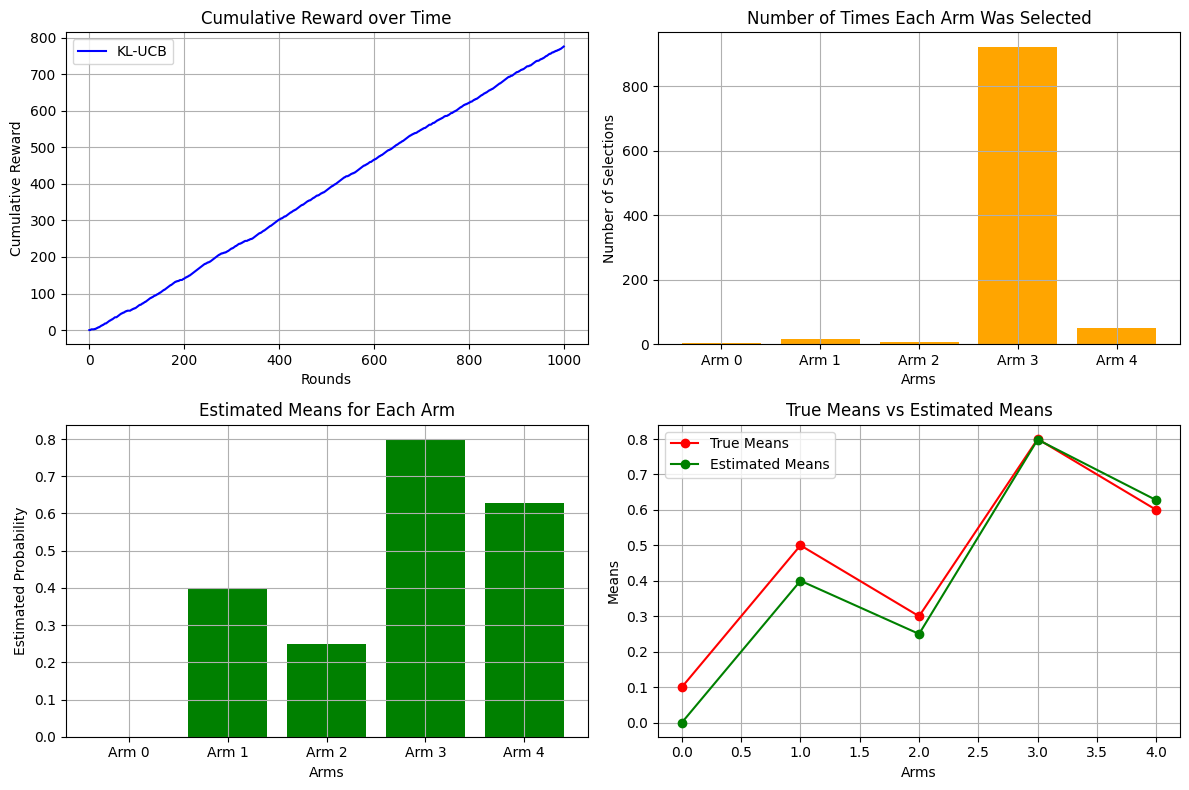

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

# KL divergence function for Bernoulli distributions
def kl_divergence(p, q):
    # Clip probabilities to avoid issues with log(0)
    p = np.clip(p, 1e-15, 1-1e-15)
    q = np.clip(q, 1e-15, 1-1e-15)
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

# KL-UCB algorithm to select the optimal arm in each round
def kl_ucb_algorithm(n_arms, n_rounds, true_means):
    rewards = np.zeros(n_rounds)  # To store rewards at each round
    counts = np.zeros(n_arms)     # Track how many times each arm was selected
    estimated_means = np.zeros(n_arms)  # Track the estimated probability of each arm

    # Initialization: pull each arm once
    for i in range(n_arms):
        reward = bernoulli.rvs(true_means[i])  # Get reward from true distribution
        rewards[i] = reward
        counts[i] += 1
        estimated_means[i] = reward  # Estimate equals to reward for first pull

    # Main loop: pull arms for the remaining rounds
    for t in range(n_arms, n_rounds):
        ucb_values = np.zeros(n_arms)  # Upper confidence bounds for each arm

        # Calculate UCB for each arm based on KL divergence
        for i in range(n_arms):
            q_max = 1  # Start with the maximum possible value for the bound
            while kl_divergence(estimated_means[i], q_max) > np.log(t + 1) / counts[i]:
                q_max -= 1e-4  # Gradually reduce q_max to satisfy the KL constraint
            ucb_values[i] = q_max  # Set UCB value to the highest valid q_max

        # Select the arm with the highest UCB value
        arm = np.argmax(ucb_values)
        reward = bernoulli.rvs(true_means[arm])  # Simulate pulling the selected arm
        rewards[t] = reward

        # Update counts and re-estimate the mean for the selected arm
        counts[arm] += 1
        estimated_means[arm] = (estimated_means[arm] * (counts[arm] - 1) + reward) / counts[arm]

    return rewards.cumsum(), counts, estimated_means

# Parameters for the simulation
n_arms = 5
true_means = [0.1, 0.5, 0.3, 0.8, 0.6]  # True reward probabilities for each arm
n_rounds = 1000

# Run KL-UCB algorithm
cumulative_rewards, counts, estimated_means = kl_ucb_algorithm(n_arms, n_rounds, true_means)

# Visualizations
plt.figure(figsize=(12, 8))

# Plot cumulative rewards over time
plt.subplot(2, 2, 1)
plt.plot(np.arange(n_rounds), cumulative_rewards, label='KL-UCB', color='b')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()
plt.grid()

# Bar chart of how many times each arm was selected
plt.subplot(2, 2, 2)
plt.bar(np.arange(n_arms), counts, color='orange')
plt.xlabel('Arms')
plt.ylabel('Number of Selections')
plt.title('Number of Times Each Arm Was Selected')
plt.xticks(np.arange(n_arms), [f'Arm {i}' for i in range(n_arms)])
plt.grid()

# Estimated probabilities for each arm
plt.subplot(2, 2, 3)
plt.bar(np.arange(n_arms), estimated_means, color='green')
plt.xlabel('Arms')
plt.ylabel('Estimated Probability')
plt.title('Estimated Means for Each Arm')
plt.xticks(np.arange(n_arms), [f'Arm {i}' for i in range(n_arms)])
plt.grid()

# Plot of true means vs estimated means for each arm
plt.subplot(2, 2, 4)
plt.plot(np.arange(n_arms), true_means, 'ro-', label='True Means')
plt.plot(np.arange(n_arms), estimated_means, 'go-', label='Estimated Means')
plt.xlabel('Arms')
plt.ylabel('Means')
plt.title('True Means vs Estimated Means')
plt.legend()
plt.grid()

# Show the overall figure
plt.tight_layout()
plt.show()
